# Fairness Analysis On Bank Term Deposit Marketing

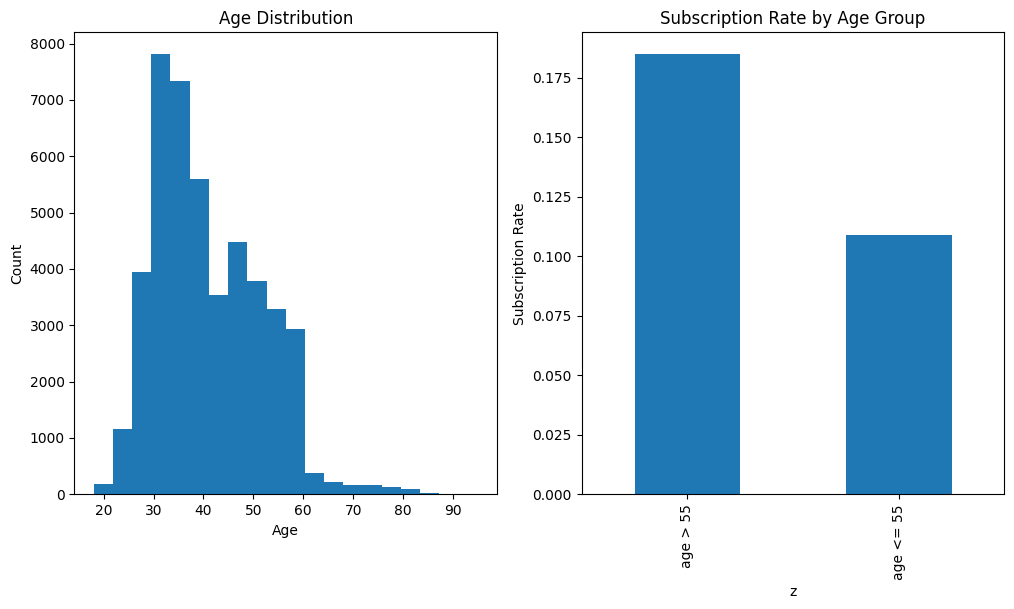

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# df = pd.read_csv("data/bank-additional-full.csv", sep=";")
df = pd.read_csv("data/bank-full.csv", sep=";")

# Convert target variable to binary (0 = No, 1 = Yes)
df["y"] = df["y"].apply(lambda x: 0 if x == "no" else 1)
# Create a new sensitive variable z. z = 0 age > 55, z = 1 age <= 55
df["z"] = df["age"].apply(lambda x: 0 if x > 55 else 1)

# Plot histogram of age groups and subscription rate by group
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

df["age"].plot(kind="hist", bins=20, ax=axes[0])
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")
axes[0].set_title("Age Distribution")

df.groupby("z")["y"].mean().plot(kind="bar", ax=axes[1])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["age > 55", "age <= 55"])
axes[1].set_ylabel("Subscription Rate")
axes[1].set_title("Subscription Rate by Age Group")
plt.show()

## Build training/test splits and train a logistic regression model

In [188]:
df_encoded = df.copy()
# Convert categorical variables to numerical
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day", "poutcome"]
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])

# Scale the numerical variables
numerical_cols = ["balance", "duration", "campaign", "pdays", "previous"]
for col in numerical_cols:
    ss = StandardScaler()
    df_encoded[col] = ss.fit_transform(df_encoded[[col]])


# Form the training/testing data
X = df_encoded.drop(columns=["y"])
y = df_encoded["y"]
Z = df_encoded["z"]
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression(C=1, max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

def compute_group_rates(y_true, y_pred, Z_test, group):
    group_idx = (Z_test == group)
    tp = np.sum((y_true[group_idx] == 1) & (y_pred[group_idx] == 1))
    fp = np.sum((y_true[group_idx] == 0) & (y_pred[group_idx] == 1))
    tn = np.sum((y_true[group_idx] == 0) & (y_pred[group_idx] == 0))
    fn = np.sum((y_true[group_idx] == 1) & (y_pred[group_idx] == 0))
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return tpr, fpr, tnr, fnr

for group in [0, 1]:
    print(f"Age Group {group}: {compute_group_rates(y_test, y_pred, Z_test, group)}")

print("Number of people over 55:", np.sum(Z_test == 0))
print("Number of people under 55:", np.sum(Z_test == 1))

Accuracy: 0.8026097534004202
Age Group 0: (0.8736842105263158, 0.36075949367088606, 0.6392405063291139, 0.12631578947368421)
Age Group 1: (0.7869034406215316, 0.17927953085730242, 0.8207204691426976, 0.21309655937846836)
Number of people over 55: 980
Number of people under 55: 8063


For this problem, the bank is most interested in getting the most amount of people subscribed to a term deposit. So, we would be OK with maximizing TPR at the cost of a decrease in total accuracy or increase in false positive rate.

Looking at the TPR and FPR, there is a large disparity between the two groups. The true positive rate for people over 55 is over % higher than those under 55. It's also important to consider that there are 8063 people in the test set for people under 55, but only 980 people over 55 -- we are potentially missing a large amount of subscribers because of the discrepancy in age. Age is probably an important feature in predicting subscription to a term deposit, but it's also probably heavily correlated with things like having a housing loan, martial status, etc. Let's take a look at which coefficients are most informative in prediction.

In [192]:
# Zip the column name with the coefficient trained in the model
coefficients = dict(zip(X.columns, model.coef_[0]))
# Sort the coefficients by value (descending in order of absolute value)
sorted_coefficients = sorted(coefficients.items(), key=lambda x: abs(x[1]), reverse=True)
# Print the top 10 coefficients
for i in range(10):
    print(sorted_coefficients[i])

('duration', 1.3901681085063329)
('housing', -1.1037983816469672)
('loan', -0.7329727937396009)
('contact', -0.7104849649493434)
('z', -0.6878909265760553)
('default', -0.5105787408054546)
('campaign', -0.43178458515097423)
('previous', 0.35647015024247075)
('pdays', 0.32025763196043755)
('education', 0.23418590850914506)


For a bank that wanted to get more subscribers, we may want to look at improving the fairness of our classifier. Currently, we discriminate against younger people (younger than 55) comparing the TPR of each group in the sensitive attribute. Potentially, we don't really care about a few failed calls, so it's not a big deal if the FPR increases, but we should try to match the TPR of each group (ideally, just increase TRP of the lower performing group). For this type of problem, using **equal opportunity** as our fairness definition makes the most sense since we only really care about positive outcomes, and don't mind the cost of a bit of time for a false positive. We mostly care that the probability of a person in a positive class being assigned a positive outcome should be equal for both the protected and unprotected group.

In [196]:
tpr_0, _, _, _ = compute_group_rates(y_test, y_pred, Z_test, 0)
tpr_1, _, _, _ = compute_group_rates(y_test, y_pred, Z_test, 1)

equal_opp = tpr_0 / tpr_1
print("Equal Opportunity Ratio:", equal_opp)

Equal Opportunity Ratio: 1.1102813451117215


Ideally, to obtain true equal opportunity, we want this ratio to become as close to 1 as possible, ideally at minimal loss of accuracy and wihout decreasing the TPR of the unprotected group.